In [1]:
# Addd by Mohsen
!pip install rarfile --quiet
!pip install stable-baselines3 > /dev/null
!pip install box2d-py > /dev/null
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
# install dependencies
!pip3 install gym --upgrade
!pip3 install pyglet
!pip3 install Box2D
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 694 kB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.24.0-py3-none-any.whl size=790706 sha256=a8f796366cec8941787b5fad4e4840db16a27f65531366cd75bcf7b8fd95f4ca
  Stored in directory: /root/.cache/pip/wheels/68/7a/27/ac44ac6e4763637d0ed8d89f686465960f9837440ee880abe6
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.21.0
    Uninstalling gym-0.21.0:
      Successfully uninstalled gym-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 1.5.0 requires gym==0.21, but you have gym 0.24.0 which is incompatible.
Looking in indexes: https://pypi.

In [1]:
import torch

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

The input state of the Lunar Lander consists of following components:

  1. Horizontal Position
  2. Vertical Position
  3. Horizontal Velocity
  4. Vertical Velocity
  5. Angle
  6. Angular Velocity
  7. Left Leg Contact
  8. Right Leg Contact

The actions of the agents are:
  1. Do Nothing
  2. Fire Main Engine
  3. Fire Left Engine
  4. Fire Right Engine

In [2]:
# enviroment
import gym
env = gym.make('LunarLander-v2')
#TODO: find observation size: 8
state_size = env.observation_space.shape[0] 
#TODO: find action size: 4: 0- Do nothing 1- Fire left engine 2- Fire down engine 3- Fire right engine
action_size = env.action_space.n 
state_size, action_size

(8, 4)

In [3]:
# VIDEO
import io
import os
import glob
import torch
import base64
import stable_baselines3
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env
import gym
from gym import spaces
from gym.wrappers import RecordVideo
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [4]:
# experience replay
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ExperienceReplay():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)
        
    def store_trans(self, s, a, sp, r, done):
        # TODO: store new transition in memory
        transition = Transition(s, a, sp, r, done)
        self.memory.append(transition)

    def sample(self, batch_size):
        # TODO: take RANDOM sample from memory
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
# DQN
import torch.nn as nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super(DeepQNetwork, self).__init__()
        # TODO: define the architecture
        # NOTE: input=observation/state, output=action
        net_list = nn.ModuleList([
            torch.nn.Linear(state_size, 512),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(512),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(512),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, action_size)       
        ])
        self.net = torch.nn.Sequential(*net_list).to(device)

    def forward(self, x):
        # TODO: forward propagation
        # NOTE: use ReLu for activation function in all layers 
        # NOTE: last layer has no activation function (predict action)
        # ReLU is created in init, no need here
        x.to(device)
        x = self.net(x)
        return x

## DQN

In [6]:
# DQN agent
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.experience_replay = ExperienceReplay(buffer_size)

        # network
        self.value_net = DeepQNetwork(state_size, action_size).to(device)

        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)

    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        # NOTE: 
        self.value_net.eval()
        rand_eps = random.random()
        if rand_eps > eps:
            with torch.no_grad():
                return torch.argmax(self.value_net(torch.tensor(state).to(device))).detach().cpu().numpy()
        else:
            return np.random.randint(0, self.action_size)

    def update_params(self):
        if len(self.experience_replay) < self.batch_size:
            return
        # transition batch
        batch = Transition(*zip(*self.experience_replay.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)  # [8, 8]
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device) # [8, 1]
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device) # [8, 8]
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device) # [8, 1]
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)

        # calculate loss w.r.t DQN algorithm
        self.value_net.train()
        # STEP1
        q_expected = self.value_net(state_batch).gather(1, action_batch)
        # TODO: compute the expected Q values [y]
        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        q_targets_next = self.value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        q_targets = reward_batch + (self.gamma * q_targets_next * (1 - done_batch*1))
        # STEP3
        # TODO: compute mse loss
        loss = nn.functional.mse_loss(q_expected, q_targets)
        # TODO: optimize the model
        # NOTE: DON'T forget to set the gradients to zeros
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save(self, fname):
        # TODO: save checkpoint
        torch.save(self.value_net, fname)

    def load(self, fname, device):
        # TODO: load checkpoint
        self.value_net = torch.load(fname, device)

In [7]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 32

In [8]:
# training phase

# TODO: create agent
agent = DQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 50 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    while not done:
        env.render()
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
#         print(action)
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_replay.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward
        
    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"q_net_batch{BATCH_SIZE}_eps{i_episode}.pt")
        
    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

Episode 25	Average Reward: -75.33	Epsilon: 0.47
Episode 50	Average Reward: 9.78	Epsilon: 0.22
Episode 75	Average Reward: 148.94	Epsilon: 0.10
Episode 100	Average Reward: 231.13	Epsilon: 0.05
Episode 125	Average Reward: 199.42	Epsilon: 0.02
Episode 150	Average Reward: 236.35	Epsilon: 0.01
Episode 175	Average Reward: 207.80	Epsilon: 0.01
Episode 200	Average Reward: 248.65	Epsilon: 0.01
Episode 225	Average Reward: 264.41	Epsilon: 0.01
Episode 250	Average Reward: 262.38	Epsilon: 0.01


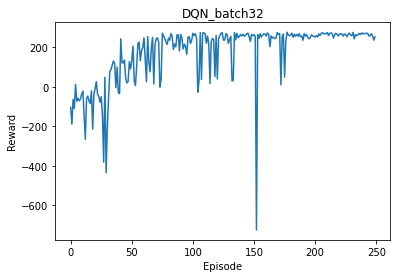

  adding: DQN/ (stored 0%)
  adding: DQN/batch32/ (stored 0%)
  adding: DQN/batch32/eps50/ (stored 0%)
  adding: DQN/batch32/eps50/rl-video-episode-0.mp4 (deflated 19%)
  adding: DQN/batch32/eps50/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch32/eps30/ (stored 0%)
  adding: DQN/batch32/eps30/rl-video-episode-0.mp4 (deflated 16%)
  adding: DQN/batch32/eps30/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch32/eps20/ (stored 0%)
  adding: DQN/batch32/eps20/rl-video-episode-0.mp4 (deflated 9%)
  adding: DQN/batch32/eps20/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch32/eps250/ (stored 0%)
  adding: DQN/batch32/eps250/rl-video-episode-0.mp4 (deflated 14%)
  adding: DQN/batch32/eps250/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch32/eps10/ (stored 0%)
  adding: DQN/batch32/eps10/rl-video-episode-0.mp4 (deflated 9%)
  adding: DQN/batch32/eps10/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch32/eps200/ (stored 0%)


In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DQN_batch{BATCH_SIZE}")
plt.savefig(f"DQN_batch{BATCH_SIZE}.pdf")
plt.show()
! zip -r DQN.zip DQN/

# Batch 64

In [13]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 64

Episode 25	Average Reward: -80.90	Epsilon: 0.47
Episode 50	Average Reward: 67.15	Epsilon: 0.22
Episode 75	Average Reward: 206.00	Epsilon: 0.10
Episode 100	Average Reward: 215.65	Epsilon: 0.05
Episode 125	Average Reward: 262.25	Epsilon: 0.02
Episode 150	Average Reward: 259.72	Epsilon: 0.01
Episode 175	Average Reward: 261.68	Epsilon: 0.01
Episode 200	Average Reward: 267.01	Epsilon: 0.01
Episode 225	Average Reward: 264.49	Epsilon: 0.01
Episode 250	Average Reward: 266.51	Epsilon: 0.01


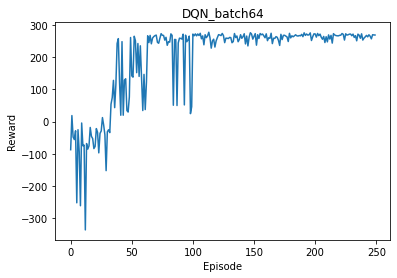

  adding: DQN/ (stored 0%)
  adding: DQN/batch32/ (stored 0%)
  adding: DQN/batch32/eps50/ (stored 0%)
  adding: DQN/batch32/eps50/rl-video-episode-0.mp4 (deflated 19%)
  adding: DQN/batch32/eps50/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch32/eps30/ (stored 0%)
  adding: DQN/batch32/eps30/rl-video-episode-0.mp4 (deflated 16%)
  adding: DQN/batch32/eps30/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch32/eps20/ (stored 0%)
  adding: DQN/batch32/eps20/rl-video-episode-0.mp4 (deflated 9%)
  adding: DQN/batch32/eps20/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch32/eps250/ (stored 0%)
  adding: DQN/batch32/eps250/rl-video-episode-0.mp4 (deflated 14%)
  adding: DQN/batch32/eps250/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch32/eps10/ (stored 0%)
  adding: DQN/batch32/eps10/rl-video-episode-0.mp4 (deflated 9%)
  adding: DQN/batch32/eps10/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch32/eps200/ (stored 0%)


In [14]:
# training phase

# TODO: create agent
agent = DQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 50 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    while not done:
        env.render()
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_replay.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward
        
    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"q_net_batch{BATCH_SIZE}_eps{i_episode}.pt")
        
    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

fig = plt.figure()
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DQN_batch{BATCH_SIZE}")
plt.savefig(f"DQN_batch{BATCH_SIZE}.pdf")
plt.show()
! zip -r DQN2.zip DQN/

# BATCH 128

In [16]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 128

Episode 25	Average Reward: -106.90	Epsilon: 0.47
Episode 50	Average Reward: -62.81	Epsilon: 0.22
Episode 75	Average Reward: 135.10	Epsilon: 0.10
Episode 100	Average Reward: 236.46	Epsilon: 0.05
Episode 125	Average Reward: 241.89	Epsilon: 0.02
Episode 150	Average Reward: 262.01	Epsilon: 0.01
Episode 175	Average Reward: 265.04	Epsilon: 0.01
Episode 200	Average Reward: 258.39	Epsilon: 0.01
Episode 225	Average Reward: 265.40	Epsilon: 0.01
Episode 250	Average Reward: 257.35	Epsilon: 0.01


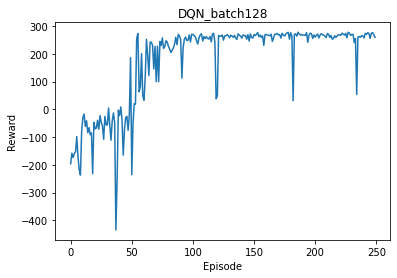

  adding: DQN/ (stored 0%)
  adding: DQN/batch128/ (stored 0%)
  adding: DQN/batch128/eps50/ (stored 0%)
  adding: DQN/batch128/eps50/rl-video-episode-0.mp4 (deflated 13%)
  adding: DQN/batch128/eps50/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch128/eps250/ (stored 0%)
  adding: DQN/batch128/eps250/rl-video-episode-0.mp4 (deflated 17%)
  adding: DQN/batch128/eps250/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch128/eps200/ (stored 0%)
  adding: DQN/batch128/eps200/rl-video-episode-0.mp4 (deflated 15%)
  adding: DQN/batch128/eps200/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch128/eps100/ (stored 0%)
  adding: DQN/batch128/eps100/rl-video-episode-0.mp4 (deflated 15%)
  adding: DQN/batch128/eps100/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/batch128/eps150/ (stored 0%)
  adding: DQN/batch128/eps150/rl-video-episode-0.mp4 (deflated 16%)
  adding: DQN/batch128/eps150/rl-video-episode-0.meta.json (deflated 60%)
  adding: DQN/b

In [17]:
# training phase

# TODO: create agent
agent = DQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 50 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    while not done:
        env.render()
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_replay.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward
        
    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"q_net_batch{BATCH_SIZE}_eps{i_episode}.pt")
        
    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

fig = plt.figure()
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DQN_batch{BATCH_SIZE}")
plt.savefig(f"DQN_batch{BATCH_SIZE}.pdf")
plt.show()
! zip -r DQN3.zip DQN/

## DDQN

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

class DDQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.experience_buffer = ExperienceReplay(buffer_size)

        # networks
        self.value_net = DeepQNetwork(state_size, action_size).to(device)
        self.target_value_net = DeepQNetwork(state_size, action_size).to(device)
        self.update_target_network()

        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        # NOTE: target network parameters DOSEN'T update with optimizer
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)

    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        # NOTE: 
        self.value_net.eval()
        rand_eps = random.random()
        if rand_eps > eps:
            with torch.no_grad():
                return torch.argmax(self.value_net(torch.tensor(state).to(device))).detach().cpu().numpy()
        else:
            return np.random.randint(0, self.action_size)

    def update_params(self):
        if len(self.experience_buffer) < self.batch_size:
            return
        # transition batch
        batch = Transition(*zip(*self.experience_buffer.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)

        # calculate loss w.r.t DQN algorithm
        self.value_net.train()
        # STEP1
        q_targets_next = self.target_value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        q_targets = reward_batch + self.gamma * q_targets_next * (1 - done_batch*1)
        q_expected = self.value_net(state_batch).gather(1, action_batch)
        # STEP3
        # TODO: compute mse loss
        loss = nn.functional.mse_loss(q_expected, q_targets)
        # TODO: optimize the model
        # NOTE: DON'T forget to set the gradients to zeros
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        # TODO: copy main network parameters to target network parameters
        self.target_value_net = copy.deepcopy(self.value_net)

    def save(self, fname):
        # TODO: save checkpoint
        torch.save(self.value_net, fname)

    def load(self, fname, device):
        # TODO: load checkpoint
        self.value_net = torch.load(fname, device)

In [25]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 64

In [27]:
# training phase

# TODO: create agent
agent = DDQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 50 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DDQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    action_count = 0
    while not done:
        env.render()
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_buffer.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward
        action_count += 1
        if action_count % 5 == 0:
            agent.update_target_network()

    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)

    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)

    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"q_net_batch{BATCH_SIZE}_eps{i_episode}.pt")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

Episode 25	Average Reward: -59.39	Epsilon: 0.47
Episode 50	Average Reward: 59.12	Epsilon: 0.22
Episode 75	Average Reward: 142.09	Epsilon: 0.10
Episode 100	Average Reward: 228.12	Epsilon: 0.05
Episode 125	Average Reward: 225.84	Epsilon: 0.02
Episode 150	Average Reward: 250.73	Epsilon: 0.01
Episode 175	Average Reward: 253.84	Epsilon: 0.01
Episode 200	Average Reward: 264.92	Epsilon: 0.01
Episode 225	Average Reward: 259.71	Epsilon: 0.01
Episode 250	Average Reward: 268.91	Epsilon: 0.01


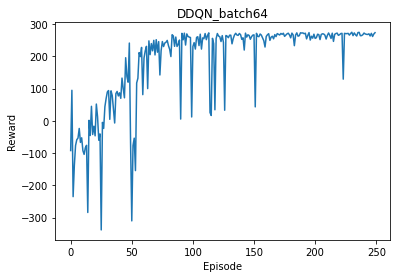

  adding: DDQN/ (stored 0%)
  adding: DDQN/batch64/ (stored 0%)
  adding: DDQN/batch64/eps50/ (stored 0%)
  adding: DDQN/batch64/eps50/rl-video-episode-0.mp4 (deflated 11%)
  adding: DDQN/batch64/eps50/rl-video-episode-0.meta.json (deflated 60%)
  adding: DDQN/batch64/eps250/ (stored 0%)
  adding: DDQN/batch64/eps250/rl-video-episode-0.mp4 (deflated 16%)
  adding: DDQN/batch64/eps250/rl-video-episode-0.meta.json (deflated 60%)
  adding: DDQN/batch64/eps200/ (stored 0%)
  adding: DDQN/batch64/eps200/rl-video-episode-0.mp4 (deflated 17%)
  adding: DDQN/batch64/eps200/rl-video-episode-0.meta.json (deflated 60%)
  adding: DDQN/batch64/eps100/ (stored 0%)
  adding: DDQN/batch64/eps100/rl-video-episode-0.mp4 (deflated 13%)
  adding: DDQN/batch64/eps100/rl-video-episode-0.meta.json (deflated 60%)
  adding: DDQN/batch64/eps150/ (stored 0%)
  adding: DDQN/batch64/eps150/rl-video-episode-0.mp4 (deflated 14%)
  adding: DDQN/batch64/eps150/rl-video-episode-0.meta.json (deflated 60%)


In [28]:
fig = plt.figure()
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DDQN_batch{BATCH_SIZE}")
plt.savefig(f"DDQN_batch{BATCH_SIZE}.pdf")
plt.show()
! zip -r DDQN3.zip DDQN/